## Developing a 'radar wetlands insight tool'

Setup and imports - note dependencies on other DEA scripts

In [2]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight

In [3]:
#setup radar dc
dc = datacube.Datacube(config='radar.conf')
#optical datacube - the radar one is separate and does not duplicate the Landsat archive
dcO = datacube.Datacube()

In [4]:
#load SAR data
#define the time period
qtime = ('2016-09-01', '2019-06-01')

query = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
#mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
#                                           out_shape=sardata.geobox.shape,
#                                           transform=sardata.geobox.affine,
#                                           all_touched=False,
#                                           invert=False)
#clean=clean.where(~mask)

#drop scenes with a lot of NaN pixels
nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

clean = clean.sel(time = valtimes)

#'vh_over_vv' channel
clean['vh_over_vv'] = clean.vh/clean.vv

#Take the natural logarithm of the backscatter to improve differentiation of dark areas
logclean = np.log(clean)

In [15]:
wit_arr = wetlands_insight.WIT_array(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [14]:
import imp
imp.reload(wetlands_insight)

<module 'wetlands_insight' from './10_Scripts/wetlands_insight.py'>

In [11]:
logclean.dims['x']

488

In [48]:
wit_arr.time.data

array(['2016-09-11T01:17:14.000000000', '2016-10-13T01:17:20.000000000',
       '2016-12-16T01:17:16.500000000', '2017-04-23T01:16:23.000000000',
       '2017-05-09T01:16:22.000000000', '2017-05-25T01:16:33.000000000',
       '2017-06-26T01:16:46.000000000', '2017-07-12T01:16:49.000000000',
       '2017-07-28T01:16:56.500000000', '2017-08-29T01:17:06.500000000',
       '2017-09-14T01:17:07.000000000', '2017-10-16T01:17:18.000000000',
       '2018-02-05T01:16:52.000000000', '2018-04-10T01:16:22.500000000',
       '2018-04-26T01:16:13.000000000', '2018-05-28T01:15:51.000000000',
       '2018-06-13T01:15:52.500000000', '2018-06-29T01:16:03.000000000',
       '2018-07-15T01:16:10.500000000', '2018-07-31T01:16:18.000000000',
       '2018-08-16T01:16:27.000000000', '2018-09-01T01:16:34.000000000',
       '2018-09-17T01:16:38.000000000', '2018-10-03T01:16:46.000000000',
       '2018-10-19T01:16:52.000000000', '2018-12-06T01:16:54.500000000',
       '2019-01-07T01:16:52.000000000', '2019-02-24

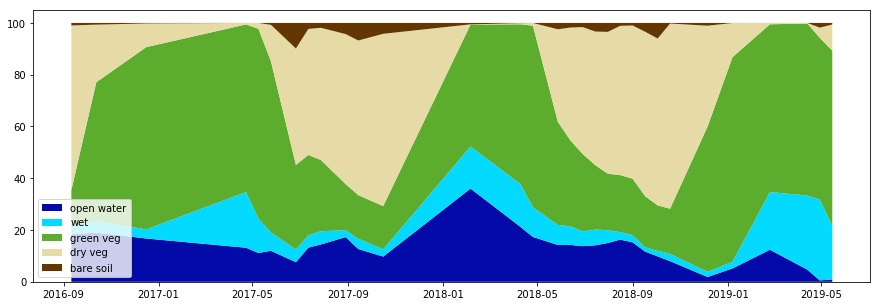

In [56]:
import seaborn as sns

plt.subplots(1,1,figsize=(15,5))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

In [29]:
import radar_gmm as rg

In [40]:
kmm = rg.fit_kmeans(logclean.isel(time=-25),n_components=4)

In [ ]:
#multiprocessing routine to speed up the timeseries calculation
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(clean.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(logclean,kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1]}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

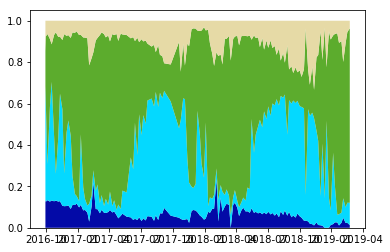

In [61]:
plt.stackplot(t.data,ts.transpose(),colors=pal)

In [62]:
kmm.cluster_centers_

array([[-5.0494337, -6.004362 , -0.9549273],
       [-2.596185 , -4.0509753, -1.454791 ],
       [-1.9442637, -3.3867054, -1.4424436],
       [-3.086841 , -4.821697 , -1.7348541]], dtype=float32)

In [105]:
imp.reload(wetlands_insight)

<module 'wetlands_insight' from './10_Scripts/wetlands_insight.py'>

In [106]:
covclass = wetlands_insight.WIT_da(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [107]:
covclass

<xarray.DataArray 'maxFC' (time: 31, y: 264, x: 488)>
array([[[3., 3., ..., 4., 4.],
        [3., 3., ..., 4., 4.],
        ...,
        [4., 4., ..., 4., 4.],
        [4., 4., ..., 4., 4.]],

       [[3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.],
        ...,
        [4., 4., ..., 3., 3.],
        [4., 4., ..., 3., 3.]],

       ...,

       [[1., 1., ..., 3., 3.],
        [1., 1., ..., 3., 3.],
        ...,
        [3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.]],

       [[3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.],
        ...,
        [3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-09-11T01:17:14 ... 2019-05-15T01:16:35
  * y        (y) float64 -1.334e+06 -1.334e+06 ... -1.34e+06 -1.34e+06
  * x        (x) float64 5.854e+04 5.856e+04 5.859e+04 ... 7.069e+04 7.071e+04

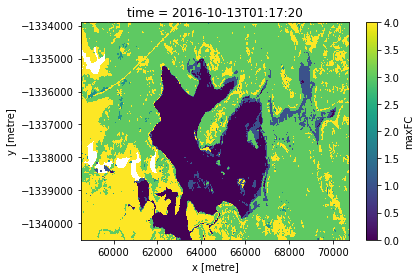

In [116]:
covclass.isel(time=1).plot()

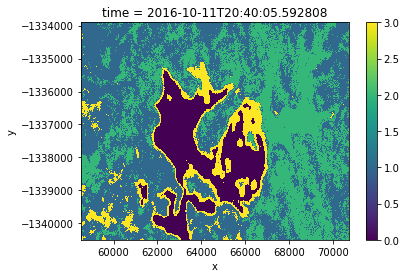

In [115]:
rg.plot_gmm_classes(logclean.isel(time=3),kmm)

By inspection of cotemporal SAR-KMM and WIT classifier images, we can make the following correspondences:

| Name | SAR class | WIT class |
| --- | --- | --- |
| open water | 0 | 0 |
| 'wet' | 3 | 1 |
| PV/'green' | 2 | 3 |
| NPV/'beige' | 1 | 4 |

Class pickup is far from perfect, but hopefully will give a good idea of what is going on in the wetland on a seasonal, whole-scene scale. Note that class 2 (bare soil) in the WIT is almost totally missing in this region and so has no corresponding SAR-KMM class.

The SAR class numbers may vary based on the stochastic initial parameters of the KMM, so it helps to sort the cluster centres in some way to assign consistent labels to the classes. We could do this, for example, in terms of the norm of the cluster centre vectors. Let's do this now.

In [117]:
kmm.cluster_centers_

array([[-5.0494337, -6.004362 , -0.9549273],
       [-2.596185 , -4.0509753, -1.454791 ],
       [-1.9442637, -3.3867054, -1.4424436],
       [-3.086841 , -4.821697 , -1.7348541]], dtype=float32)

In [139]:
kmm.cluster_centers_ = kmm.cluster_centers_[np.argsort(-np.linalg.norm(kmm.cluster_centers_,axis=1))]

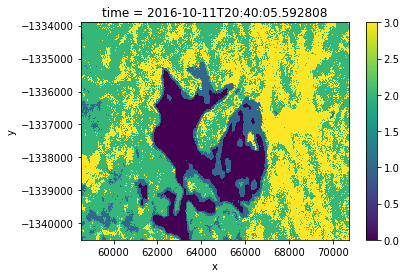

In [140]:
rg.plot_gmm_classes(logclean.isel(time=3),kmm)

The class table now looks like this and should be consistent between runs of the clustering algorithm, at least in this region:

| Name | SAR class | WIT class |
| --- | --- | --- |
| open water | 0 | 0 |
| 'wet' | 1 | 1 |
| PV/'green' | 3 | 3 |
| NPV/'beige' | 2 | 4 |

Unfortunately the ordering of green and beige veg classes needs to be the same so we can directly compare the stack plots between SAR and optical analysis. We can fix this simply by a hard reindexing of the cluster centre array:

In [141]:
kmm.cluster_centers_ = kmm.cluster_centers_[[0,1,3,2]]

Now let's make the stack plot and compare the SAR classes to the WIT ones over time.

In [147]:
#calc the timeseries with the new KMM clusters
pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(clean.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(logclean,kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1]}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

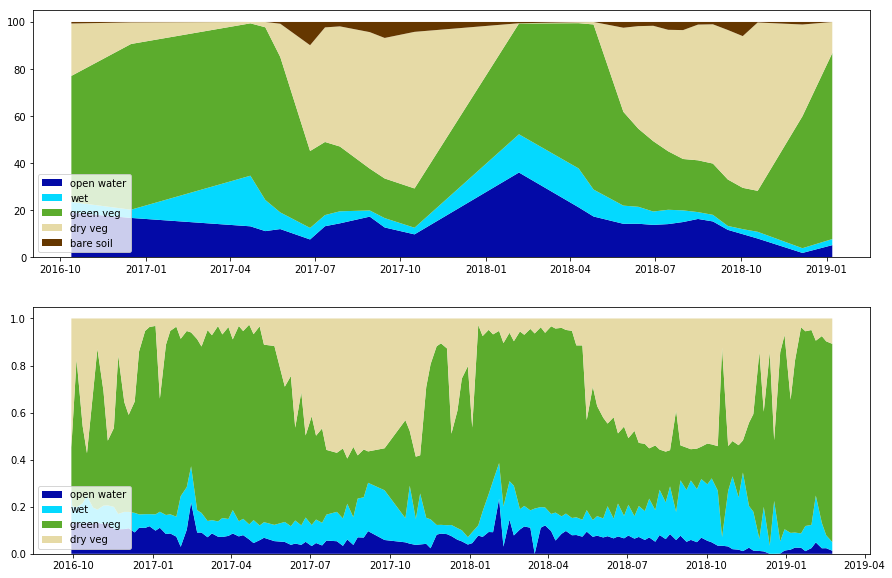

In [153]:
#the optical data covers a longer time period than the SAR so let's truncate it
wit_arr = wit_arr.sel(time=slice(t[0],t[-1]))

fig,ax = plt.subplots(2,1,figsize=(15,10))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.sca(ax[0])
plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

plt.sca(ax[1])
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"]]
plt.stackplot(t.data,ts.transpose(),labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg'
                     ], colors=pal)

plt.legend(loc='lower left')